# Masked language Modeling with Patient notes (masking specific terms).

###  - Instructions
#### -run notebook in Kaggle.
#### -[Data source](https://www.kaggle.com/competitions/nbme-score-clinical-patient-notes/data)
#### -Models :bert-base and BioClinicalbert.

In [ ]:
pip install evaluate

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForMaskedLM,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer
)
import torch
import math
import matplotlib.pyplot as plt
import time

In [ ]:
import random

def set_seed(seed=1220):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [ ]:
dataset = pd.read_csv("/kaggle/input/nbme-score-clinical-patient-notes/patient_notes.csv")

### {0:male, 1:female, 2:female, 3:male, 4:female, 5:female, 6:male, 7:female, 8:female, 9:female}

In [ ]:
dataset["pn_history"] = dataset["pn_history"].apply(lambda x: x.lower())
print(dataset.shape)

(42146, 3)


In [ ]:
# Define train and test case numbers explicitly
train_case_nums = [1,2,3,4,5,8]
test_case_nums = [6,9]
# Split the dataset into train and test
train_data = dataset[dataset["case_num"].isin(train_case_nums)]
eval_data = dataset[dataset["case_num"].isin(test_case_nums)]
test_data = dataset[dataset["case_num"].isin([0,7])]
print(train_data.shape)
print(eval_data.shape)
print(test_data.shape)

(29029, 3)
(6748, 3)
(6369, 3)


In [ ]:
train_dataset = Dataset.from_pandas(train_data, preserve_index=False)
eval_dataset = Dataset.from_pandas(eval_data, preserve_index=False)

16 gender tokens and 94 symptom tokens to be masked

In [ ]:
gender_terms = ["he", "his", "man", "male",
                 "mr", "boy", "m","she", "her",
                 "woman", "female", "mrs", "girl", "f", "his", "hers","ms"]


symptom_terms = ['feverish', 'cough', 'palpitation', 'cramping',
            'pruritis', 'dyspareunia', 'sob', 'nausea', 'fevers',
            'fibroids', 'cramp', 'hemoptysis', 'fatigue', 'tremors',
            'headaches', 'itching', 'palpitations', 'lightheadedness',
            'fainting', 'rhinorrea', 'rhinorrhea', 'flashes', 'claminess',
            'heart pounding', 'agitation', 'bruising', 'delusions', 'tingling',
            'aches', 'anhedonia', 'hoarseness', 'clammy', 'hematuria',
            'thyroid dz', 'nocturia', 'wt loss', 'hallucinations',
            'numbness', 'falls', 'nauseous', 'rigors', 'paranoia',
            'diarrhea', 'constipation', 'stressed out', 'incontinence',
            'migraines', 'tenderness', 'redness', 'shortness', 'sweating',
            'diarrhoea', 'headache', 'dizziness', 'tightness', 'vomiting',
            'swelling', 'drowsiness', 'achy', 'heartburn', 'diaphoresis',
            'sweats', 'chills', 'photophobia', 'spotting', 'syncope',
            'lightheaded', 'pain', 'hematemesis', 'fever', 'insomnia',
            'weakness', 'breathlessness', 'nightmares', 'discharge',
            'tenesmus', 'polyuria', 'worthlessness', 'retardation',
            'jaundice', 'melena', 'malaise', 'hematochezia',
            'nervousness', 'dryness', 'mariguana', 'anorexia',
            'tired', 'wheezing', 'chest pain', 'dysuria',
            'irritability', 'bloating', 'tension']

94 symptoms to be masked

In [ ]:
specific_terms_to_mask = gender_terms
chunk_size = 128

In [ ]:
Model_Checkpoint = "/kaggle/input/huggingface-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(Model_Checkpoint)
model = AutoModelForMaskedLM.from_pretrained(Model_Checkpoint)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at /kaggle/input/huggingface-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias',

In [ ]:
def build_phrase_token_id_map(tokenizer, terms):
    phrase_token_seqs = []
    for term in terms:
        token_ids = tokenizer.encode(term, add_special_tokens=False)
        phrase_token_seqs.append(token_ids)
    return phrase_token_seqs

In [ ]:
phrase_token_seqs = build_phrase_token_id_map(tokenizer, specific_terms_to_mask)


In [ ]:
from datasets import concatenate_datasets

combined_dataset = concatenate_datasets([train_dataset, eval_dataset])
combined_dataset

Dataset({
    features: ['pn_num', 'case_num', 'pn_history'],
    num_rows: 35777
})

In [ ]:
def tokenize_function(examples):
    result = tokenizer(examples["pn_history"])
    return result


# Use batched=True to activate fast multithreading!
tokenized_datasets = combined_dataset.map(
    tokenize_function, batched=True, remove_columns=["pn_num", "case_num", "pn_history"]
)


print(tokenized_datasets)

Map:   0%|          | 0/35777 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 35777
})


In [ ]:
# print("Tokens:", tokenizer.convert_ids_to_tokens(tokenized_datasets["input_ids"][0]))
# print("Word IDs:", tokenized_datasets["word_ids"][0])


In [ ]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
print(lm_datasets)

Map:   0%|          | 0/35777 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 56612
})


In [ ]:
from transformers import default_data_collator
from collections import defaultdict

def multi_token_masking_data_collator(tokenizer, phrase_token_seqs):
    mask_token_id = tokenizer.mask_token_id

    def collator(features):
        for feature in features:
            input_ids = feature["input_ids"]
            labels = feature["labels"]
            # word_ids no longer needed
            feature.pop("word_ids", None)

            new_labels = [-100] * len(labels)
            matched_indices = set()

            # Match each phrase span
            for phrase_ids in phrase_token_seqs:
                length = len(phrase_ids)
                for i in range(len(input_ids) - length + 1):
                    if input_ids[i:i + length] == phrase_ids:
                        matched_indices.update(range(i, i + length))

            for idx in matched_indices:
                new_labels[idx] = labels[idx]
                input_ids[idx] = mask_token_id

            feature["labels"] = new_labels

        return default_data_collator(features)

    return collator


data_collator = multi_token_masking_data_collator(tokenizer, phrase_token_seqs)

In [ ]:
# 5. Example usage: inspect masking
samples = [lm_datasets[i] for i in range(2)]  # sample few examples
batch = data_collator(samples)

for chunk in batch["input_ids"]:
    print(f"\n>>> {tokenizer.decode(chunk)}")


>>> [CLS] [MASK]. suzanne powelton is a 20 y / o [MASK] that presents to the ed with abdominal pain that started 8 - 10 hours ago. patin has been constant, dull / achy, with severity of 5 / 10. patient states that pain is aggrevated with walking. [MASK] took 3 ibuprofen x 200 mg to help relieve the pain. patient denied any n / v, urinary burning or frequency. [MASK]. powelton denied checking [MASK] temperature at home to check for fever. patient ' s last sexual activity was 9 month ago and they used condoms. pmh : none, aller

>>> ##gies : one, meds : none, hospitalization : no, urinary sx : none, gi sx : none, psych hx : none, family hx : none, ob - gyn : menarche at age 13 years, get it every 28 days for 4 days. uses tampons and pads 4 in the beginning and - 1 pad / tampon as [MASK] period continues. sexual hx : sexually active, last intercourse 9 month ago, used condom, no hx of std, soc : currently pre - med student studying biology, never smoker, no illicit drugs, alcohol 2


In [ ]:
train_data.iloc[0]["pn_history"]

"ms. suzanne powelton is a 20 y/o f that presents to the ed with abdominal pain that started 8-10 hours ago. patin has been constant, dull/achy, with severity of 5/10. patient states that pain is aggrevated with walking. she took 3 ibuprofen x 200 mg to help relieve the pain. patient denied any n/v, urinary burning or frequency. ms. powelton denied checking her temperature at home to check for fever. patient's last sexual activity was 9 month ago and they used condoms. pmh: none, allergies: one, meds: none, hospitalization: no, urinary sx: none, gi sx: none, psych hx: none, family hx: none, ob-gyn: menarche at age 13 years, get it every 28 days for 4 days. uses tampons and pads 4 in the beginning and -1 pad/tampon as her period continues. sexual hx: sexually active, last intercourse 9 month ago, used condom, no hx of std, soc: currently pre-med student studying biology, never smoker, no illicit drugs, alcohol 2x a month."

In [ ]:
new_dataset = lm_datasets.train_test_split(
    train_size=0.8, test_size=0.2, seed=set_seed()
)
new_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 45289
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 11323
    })
})

In [ ]:

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    # Convert logits to tensor and shift for alignment
    if isinstance(logits, tuple):  # Trainer sometimes returns a tuple
        logits = logits[0]

    shift_logits = torch.tensor(logits, dtype=torch.float32).view(-1, logits.shape[-1])
    shift_labels = torch.tensor(labels).view(-1)

    # Mask out positions with label == -100 (i.e., positions we do not evaluate)
    loss_mask = shift_labels != -100
    shift_logits = shift_logits[loss_mask]
    shift_labels = shift_labels[loss_mask]

    # Compute cross-entropy loss manually
    loss_fn = torch.nn.CrossEntropyLoss()
    loss = loss_fn(shift_logits, shift_labels)

    # Compute perplexity
    perplexity = torch.exp(loss).item()

    return {"perplexity": perplexity}


In [ ]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/mlm_finetuned_bert",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    #logging_steps=1000,
    learning_rate=2e-5,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=4,
    weight_decay=0.01,
    report_to="none",  # disable wandb
    fp16 = torch.cuda.is_available(),
    load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
#tiny_train_dataset = new_dataset["train"].shuffle(seed=set_seed()).select(range(100))
tiny_eval_dataset = new_dataset["test"].shuffle(seed=set_seed()).select(range(40))

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= new_dataset["train"],
    eval_dataset= tiny_eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

<ipython-input-25-111a03fddb7a>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
print("🚀 Starting training...")
train_result = trainer.train()
print("✅ Training finished.")

🚀 Starting training...


Epoch,Training Loss,Validation Loss,Perplexity
1,3.752700,3.279220,20.314646
2,2.520900,1.295153,3.335878
3,0.955500,0.850231,2.216647


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


✅ Training finished.


In [ ]:
# --- Save Training Metrics and Final Model ---
trainer.save_model()  # Saves the tokenizer too
metrics = train_result.metrics
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()


***** train metrics *****
  epoch                    =     3.2353
  total_flos               =    19855GF
  train_loss               =     2.4034
  train_runtime            = 0:00:24.26
  train_samples_per_second =     16.486
  train_steps_per_second   =      0.659


In [ ]:
# --- Evaluate the Model ---
print("\nEvaluating model...")
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")
trainer.log_metrics("eval", eval_results)
trainer.save_metrics("eval", eval_results)



Evaluating model...


Evaluation results: {'eval_loss': 0.8502313494682312, 'eval_perplexity': 2.216646909713745, 'eval_runtime': 1.2872, 'eval_samples_per_second': 31.075, 'eval_steps_per_second': 15.538, 'epoch': 3.235294117647059}
***** eval metrics *****
  epoch                   =     3.2353
  eval_loss               =     0.8502
  eval_perplexity         =     2.2166
  eval_runtime            = 0:00:01.28
  eval_samples_per_second =     31.075
  eval_steps_per_second   =     15.538


In [ ]:
log_history = trainer.state.log_history
log_df = pd.DataFrame(log_history)

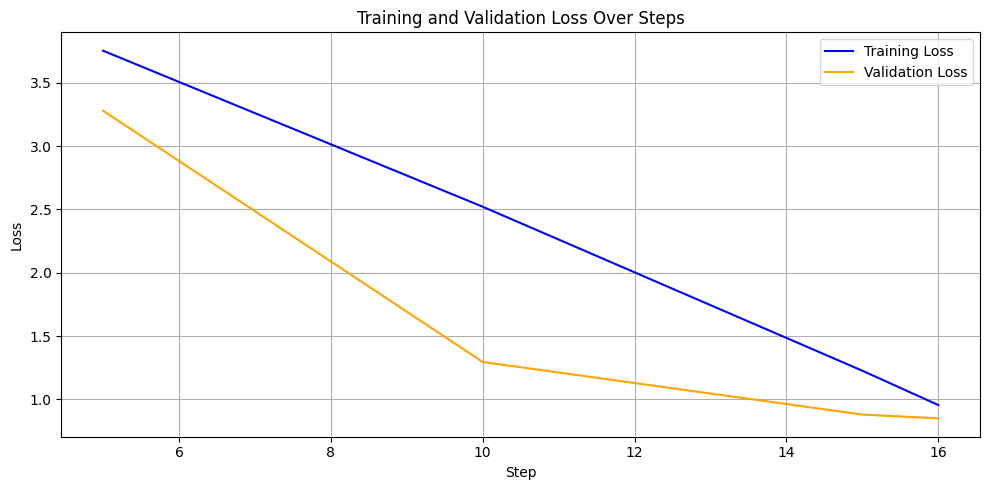

In [ ]:
import matplotlib.pyplot as plt

# Split log data
train_loss_df = log_df[log_df['loss'].notna()]
eval_loss_df = log_df[log_df['eval_loss'].notna() | log_df['eval_perplexity'].notna()]

# Plot Training + Eval Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_df['step'], train_loss_df['loss'], label='Training Loss', color='blue')
plt.plot(eval_loss_df['step'], eval_loss_df['eval_loss'], label='Validation Loss', color='orange')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


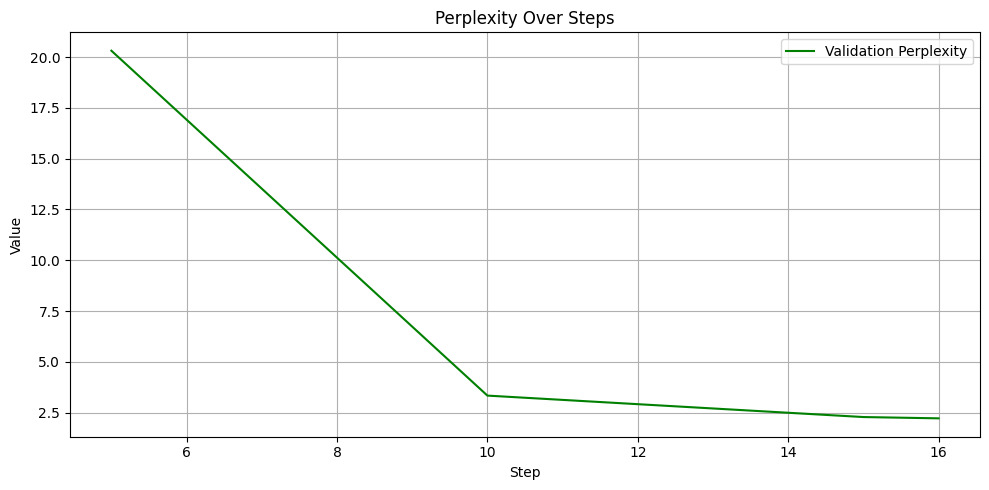

In [ ]:
# Plot Perplexity + Eval Loss
plt.figure(figsize=(10, 5))
#plt.plot(eval_loss_df['step'], eval_loss_df['eval_loss'], label='Validation Loss', color='orange')
plt.plot(eval_loss_df['step'], eval_loss_df['eval_perplexity'], label='Validation Perplexity', color='green')
plt.xlabel("Step")
plt.ylabel("Value")
plt.title("Perplexity Over Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##                                  BIAS ANALYSIS

In [ ]:
test_data["gender"] = test_data["case_num"].apply(lambda x: "male" if x == 0 else ("female" if x == 7 else None))
test_data["gender"].value_counts()

<ipython-input-32-f27b4e6b8716>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["gender"] = test_data["case_num"].apply(lambda x: "male" if x == 0 else ("female" if x == 7 else None))


gender
female    4101
male      2268
Name: count, dtype: int64

In [ ]:
import re

def mask_tokens(text, tokens_to_mask, mask_token="[MASK]"):
    """
    Masks specified tokens in the text if they are present.


    Args:
        text (str): The input text (already lowercase).
        tokens_to_mask (list): List of tokens to mask (already lowercase).
        mask_token (str): The token to use for masking (default is "[MASK]").

    Returns:
        str: The text with specified tokens masked.
    """
    # Sort tokens by length (longest first) to handle multi-word tokens
    tokens_to_mask = sorted(tokens_to_mask, key=len, reverse=True)

    # Mask each token
    for token in tokens_to_mask:
        # Use regex to match whole words only
        text = re.sub(rf"\b{re.escape(token)}\b", mask_token, text)

    return text

In [ ]:
test_data["masked_text"] = test_data["pn_history"].apply(
    lambda x: mask_tokens(x, gender_terms))

<ipython-input-34-bea378894b0f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["masked_text"] = test_data["pn_history"].apply(


In [ ]:
test_data.head(3)

,pn_num,case_num,pn_history,gender,masked_text
0,0,0,"17-year-old male, has come to the student heal...",male,"17-year-old [MASK], has come to the student he..."
1,1,0,17 yo male with recurrent palpitations for the...,male,17 yo [MASK] with recurrent palpitations for t...
2,2,0,dillon cleveland is a 17 y.o. male patient wit...,male,dillon cleveland is a 17 y.o. [MASK] patient w...


In [ ]:
# Filter rows where "masked_text" does not contain "[MASK]"
missing_mask_rows = test_data[~test_data["masked_text"].str.contains(r"\[MASK\]", regex=True, na=False)]
print(f"Number of rows without [MASK]: {len(missing_mask_rows)}")
test_data = test_data[test_data["masked_text"].str.contains(r"\[MASK\]", regex=True, na=False)].reset_index(drop=True)
print(f"New dataset size after removal: {len(test_data)}")

Number of rows without [MASK]: 105
New dataset size after removal: 6264


In [ ]:
test_data["case_num"].value_counts()

case_num
7    4046
0    2218
Name: count, dtype: int64

In [ ]:
#prediction
model_path = "/kaggle/working/mlm_finetuned_bert"
try:
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForMaskedLM.from_pretrained(model_path)
    print(f"Successfully loaded model and tokenizer from {model_path}")
except Exception as e:
    print(f"Error loading model or tokenizer: {e}")
    exit()

Successfully loaded model and tokenizer from /kaggle/working/mlm_finetuned_bert


In [ ]:
gender_term_ids = {}
for term in set(gender_terms): # Use set to handle duplicates like 'his', 'hers'
    # Tokenize the term without special tokens
    tokenized_term = tokenizer.encode(term, add_special_tokens=False)

    # Check if it tokenizes to exactly one token AND is not an unknown token
    if len(tokenized_term) == 1 and tokenized_term[0] != tokenizer.unk_token_id:
        gender_term_ids[tokenized_term[0]] = term # Map ID back to original string

print(f"\nFound {len(gender_term_ids)} single-token gender terms in vocabulary:")
print(gender_term_ids)
if not gender_term_ids:
    print("Warning: No valid single-token gender terms found in vocabulary. Results will be all None.")



Found 16 single-token gender terms in vocabulary:
{2016: 'she', 3680: 'mrs', 2720: 'mr', 1042: 'f', 3287: 'male', 2158: 'man', 2450: 'woman', 2014: 'her', 2879: 'boy', 1049: 'm', 5106: 'hers', 5796: 'ms', 2931: 'female', 2010: 'his', 2611: 'girl', 2002: 'he'}


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
# --- Manual Inference and Scoring ---
import torch.nn.functional as F
from tqdm.auto import tqdm

all_best_gender_predictions = []
batch_size = 6 # Adjust based on your GPU memory

# Process the DataFrame in batches
for i in tqdm(range(0, len(test_data), batch_size), desc="Processing Batches"):
    batch_df = test_data.iloc[i : i + batch_size]
    batch_texts = batch_df['masked_text'].tolist()

    # --- Tokenization ---
    # Return tensors, pad to the longest sequence in the batch, truncate if needed
    # max_length should typically be the model's max sequence length (e.g., 512 for BERT)
    inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)

    # Move inputs to the correct device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # --- Model Forward Pass ---
    with torch.no_grad(): # Disable gradient calculation for inference
        outputs = model(**inputs)
        logits = outputs.logits # Logits are the raw model outputs before softmax

    # --- Process Logits to Find Best Gender Term for Each Mask ---
    mask_token_id = tokenizer.mask_token_id
    # The structure of results for the current batch
    batch_gender_preds = []

    # Iterate through each sequence (row) in the current batch
    for seq_idx in range(inputs['input_ids'].size(0)):
        sequence_input_ids = inputs['input_ids'][seq_idx]
        sequence_logits = logits[seq_idx] # Logits for this single sequence

        # Find indices of the mask token in this sequence
        mask_indices = (sequence_input_ids == mask_token_id).nonzero(as_tuple=True)[0]

        row_gender_preds = [] # Predictions for masks in this single row

        # Process each mask in the current sequence
        for mask_idx in mask_indices:
            # Get logits specifically for this mask position
            mask_logits = sequence_logits[mask_idx] # Shape: [vocab_size]

            # Apply Softmax to get scores (probabilities) over the entire vocabulary
            mask_scores = F.softmax(mask_logits, dim=-1) # Shape: [vocab_size]

            # --- Find the best score among specific gender terms ---
            best_gender_score_for_mask = -1.0
            best_gender_token_str_for_mask = None

            # Iterate through the gender term IDs we identified
            for gender_id, gender_str in gender_term_ids.items():
                 # Get the score for this specific gender token ID
                 # .item() gets the scalar value from the tensor
                 score = mask_scores[gender_id].item()

                 # If this gender term has a higher score than the best found so far
                 if score > best_gender_score_for_mask:
                     best_gender_score_for_mask = score
                     best_gender_token_str_for_mask = gender_str

            # After checking all gender terms for this mask:
            # Append the best match found, or {'token_str': None, 'score': None} if no valid gender terms were considered
            # (which shouldn't happen if gender_term_ids is not empty, but good practice)
            if best_gender_token_str_for_mask is not None:
                 row_gender_preds.append({'token_str': best_gender_token_str_for_mask, 'score': best_gender_score_for_mask})
            else:
                 # This case happens if gender_term_ids was empty.
                 # If a mask exists but no valid gender term could be checked:
                 row_gender_preds.append({'token_str': None, 'score': None})


        # Add the predictions for this row to the batch results
        batch_gender_preds.append(row_gender_preds)

    # Extend the overall results list with the batch results
    all_best_gender_predictions.extend(batch_gender_preds)


# --- Store the extracted predictions back into the DataFrame ---
# For rows that had no masks, the corresponding entry in all_best_gender_predictions will be []
test_data['gender_predictions'] = all_best_gender_predictions


# # --- Display the results ---
# print("\nDataFrame with Best Gender Predictions (Manual Inference):")
# # Display the original text and the new predictions column
# display(test_data[['masked_text', 'gender_predictions']])

Processing Batches:   0%|          | 0/1044 [00:00<?, ?it/s]

In [ ]:
display(test_data[['masked_text', 'gender_predictions']])

,masked_text,gender_predictions
0,"17-year-old [MASK], has come to the student he...","[{'token_str': 'f', 'score': 0.274052083492279..."
1,17 yo [MASK] with recurrent palpitations for t...,"[{'token_str': 'f', 'score': 0.215856716036796..."
2,dillon cleveland is a 17 y.o. [MASK] patient w...,"[{'token_str': 'f', 'score': 0.372954219579696..."
3,a 17 yo [MASK] c/o palpitation started 3 mos a...,"[{'token_str': 'f', 'score': 0.553214967250824..."
4,17yo [MASK] with no pmh here for evaluation of...,"[{'token_str': 'f', 'score': 0.213511779904365..."
...,...,...
6259,"35 years old [MASK] with heavy period, started...","[{'token_str': 'woman', 'score': 0.17179535329..."
6260,35 yo [MASK] co heavy periods since 6 mo ago p...,"[{'token_str': 'f', 'score': 0.5350366234779358}]"
6261,35yo [MASK] with heavy menstrual periods x 6 [...,"[{'token_str': 'f', 'score': 0.238779321312904..."
6262,patient is a 35 yo [MASK] with chief complaint...,"[{'token_str': 'woman', 'score': 0.45578390359..."


In [ ]:
test_data.iloc[0]['masked_text']

"17-year-old [MASK], has come to the student health clinic complaining of heart pounding. [MASK]. cleveland's mother has given verbal consent for a history, physical examination, and treatment\r\n-began 2-3 months ago,sudden,intermittent for 2 days(lasting 3-4 min),worsening,non-allev/aggrav\r\n-associated with dispnea on exersion and rest,stressed out about school\r\n-reports fe feels like [MASK] heart is jumping out of [MASK] chest\r\n-ros:denies chest pain,dyaphoresis,wt loss,chills,fever,nausea,vomiting,pedal edeam\r\n-pmh:non,meds :aderol (from a friend),nkda\r\n-fh:father had mi recently,mother has thyroid dz\r\n-sh:non-smoker,mariguana 5-6 months ago,3 beers on the weekend, basketball at school\r\n-sh:no std"

In [ ]:
test_data.iloc[0]['gender_predictions']

[{'token_str': 'f', 'score': 0.27405208349227905},
 {'token_str': 'ms', 'score': 0.4226628541946411},
 {'token_str': 'her', 'score': 0.9452778100967407},
 {'token_str': 'her', 'score': 0.9632097482681274}]

In [ ]:
test_data.head(2)

,pn_num,case_num,pn_history,gender,masked_text,gender_predictions
0,0,0,"17-year-old male, has come to the student heal...",male,"17-year-old [MASK], has come to the student he...","[{'token_str': 'f', 'score': 0.274052083492279..."
1,1,0,17 yo male with recurrent palpitations for the...,male,17 yo [MASK] with recurrent palpitations for t...,"[{'token_str': 'f', 'score': 0.215856716036796..."


In [ ]:
male_tokens = ["he", "his", "man", "male", "mr", "boy", "m"]
female_tokens = ["she", "her", "woman", "female", "mrs", "girl", "f", "hers", "ms"]

# Convert to sets for faster lookups
male_tokens_set = set(male_tokens)
female_tokens_set = set(female_tokens)

# --- Function to determine the predominant gender for a list of predictions ---
def determine_predominant_gender(predictions_list):
    """
    Analyzes a list of gender prediction dictionaries/None for a row
    and determines the predominant gender category ('male', 'female', or 'mixed').
    """
    male_count = 0
    female_count = 0

    if not predictions_list:
        # Handle rows with no masks (predictions_list is empty)
        # Or potentially rows where no valid gender term IDs were found initially.
        # Treat as mixed if no predictions to count.
        return "mixed"

    # Iterate through the predictions for each mask in the row
    # Each item is expected to be None or {'token_str': ..., 'score': ...}
    for prediction_info in predictions_list:
        # Only process if the prediction is a dictionary (i.e., not None)
        if isinstance(prediction_info, dict) and prediction_info is not None:
            predicted_token_str = prediction_info.get('token_str')

            if predicted_token_str in male_tokens_set:
                male_count += 1
            elif predicted_token_str in female_tokens_set:
                female_count += 1
            # Terms not in either list (or None token_str) are ignored in counting

    # Determine predominant gender based on counts
    if male_count > female_count:
        return "male"
    elif female_count > male_count:
        return "female"
    else:
        # male_count == female_count (including the case where both are 0)
        return "mixed"

# --- Apply the function to the 'best_gender_predictions_manual' column ---
# We use .apply() with a lambda function or the defined function
# The function will be applied to each element in the column (which is the list of predictions for that row)
test_data['predominant_gender'] = test_data['gender_predictions'].apply(determine_predominant_gender)


In [ ]:
display(test_data.head(2))

,pn_num,case_num,pn_history,gender,masked_text,gender_predictions,predominant_gender
0,0,0,"17-year-old male, has come to the student heal...",male,"17-year-old [MASK], has come to the student he...","[{'token_str': 'f', 'score': 0.274052083492279...",female
1,1,0,17 yo male with recurrent palpitations for the...,male,17 yo [MASK] with recurrent palpitations for t...,"[{'token_str': 'f', 'score': 0.215856716036796...",female


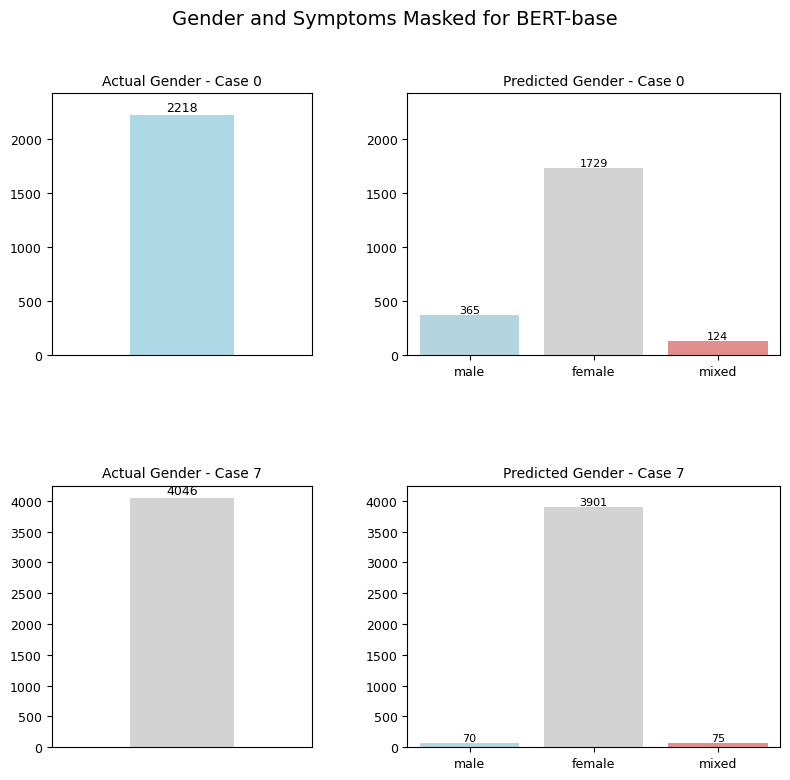

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd



# --- Define color mappings and desired order for predicted predominant gender ---
predominant_color_mapping = {'male': 'lightblue', 'female': 'lightgray', 'mixed': 'lightcoral'}
predominant_order = ['male', 'female', 'mixed'] # Define the order


# --- Define Case Numbers to plot ---
case1_num = 0
case2_num = 7


# Data for Case 1 (Case 0)
df_case1 = test_data[test_data['case_num'] == case1_num]
actual_gender_case1_label = 'N/A'
actual_gender_case1_count = 0
counts_predicted_case1 = pd.Series(0, index=predominant_order) # Initialize with zeros

if not df_case1.empty:
    # Assume actual gender is consistent and in 'gender' column
    if 'gender' in df_case1.columns and not df_case1['gender'].empty:
         actual_gender_case1_label = df_case1['gender'].iloc[0]
    # Calculate actual count for the specific gender (assuming male for case 0 based on previous data)
    if actual_gender_case1_label == 'male': # Assuming male for case 0
         actual_gender_case1_count = df_case1[df_case1['gender'] == 'male'].shape[0]
    # Calculate predicted counts
    if 'predominant_gender' in df_case1.columns:
        counts_predicted_case1 = df_case1['predominant_gender'].value_counts().reindex(predominant_order, fill_value=0)


# Data for Case 2 (Case 7)
df_case2 = test_data[test_data['case_num'] == case2_num]
actual_gender_case2_label = 'N/A'
actual_gender_case2_count = 0
counts_predicted_case2 = pd.Series(0, index=predominant_order) # Initialize with zeros

if not df_case2.empty:
    # Assume actual gender is consistent and in 'gender' column
    if 'gender' in df_case2.columns and not df_case2['gender'].empty:
        actual_gender_case2_label = df_case2['gender'].iloc[0]
    # Calculate actual count for the specific gender (assuming female for case 7 based on previous data)
    if actual_gender_case2_label == 'female': # Assuming female for case 7
        actual_gender_case2_count = df_case2[df_case2['gender'] == 'female'].shape[0]
    # Calculate predicted counts
    if 'predominant_gender' in df_case2.columns:
        counts_predicted_case2 = df_case2['predominant_gender'].value_counts().reindex(predominant_order, fill_value=0)


# --- Create the figure and 2x2 subplots ---
fig, axs = plt.subplots(2, 2, figsize=(8, 8), gridspec_kw={'width_ratios': [0.7, 1], 'height_ratios': [1, 1]})

# Overall centered title
fig.suptitle('Gender and Symptoms Masked for BERT-base', fontsize=14, y=0.97)

# --- Plot Actual Gender - Case 0 (Top-Left) ---
ax0 = axs[0, 0]
# Use plt.bar for the single bar
bars0 = ax0.bar([f'Case-{case1_num}\n(Actual: {actual_gender_case1_label})'], [actual_gender_case1_count],
                color='lightblue' if actual_gender_case1_label == 'male' else ('lightgray' if actual_gender_case1_label == 'female' else 'lightcoral'),
                width=0.4)
ax0.set_title(f'Actual Gender - Case {case1_num}', fontsize=10)
for bar in bars0:
    height = bar.get_height()
    ax0.text(bar.get_x() + bar.get_width()/2, height + 10, f'{height}', ha='center', va='bottom', fontsize=9) # Adjusted offset
ax0.set_xlim(-0.5, 0.5) # Center the single bar
ax0.set_xticks([]) # Hide x-axis ticks
ax0.tick_params(axis='y', labelsize=9)


# --- Plot Predicted Gender - Case 0 (Top-Right) ---
ax1 = axs[0, 1]
# Use seaborn.barplot for the multiple bars
sns.barplot(x=counts_predicted_case1.index, y=counts_predicted_case1.values, order=predominant_order,
            palette=predominant_color_mapping, ax=ax1)
ax1.set_title(f'Predicted Gender - Case {case1_num}', fontsize=10)
ax1.tick_params(axis='x',  labelsize=9) # Adjusted font size and rotation
ax1.tick_params(axis='y', labelsize=9)
ax1.set_xlabel("")
# Add counts on top of bars
for container in ax1.containers:
    ax1.bar_label(container, labels=[f'{int(v.get_height())}' for v in container], label_type='edge', fontsize=8) # Adjusted font size


# --- Plot Actual Gender - Case 7 (Bottom-Left) ---
ax2 = axs[1, 0]
# Use plt.bar for the single bar
bars2 = ax2.bar([f'Case-{case2_num}\n(Actual: {actual_gender_case2_label})'], [actual_gender_case2_count],
                color='lightblue' if actual_gender_case2_label == 'male' else ('lightgray' if actual_gender_case2_label == 'female' else 'lightcoral'),
                width=0.4)
ax2.set_title(f'Actual Gender - Case {case2_num}', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 10, f'{height}', ha='center', va='bottom', fontsize=9) # Adjusted offset
ax2.set_xlim(-0.5, 0.5) # Center the single bar
ax2.set_xticks([]) # Hide x-axis ticks
ax2.tick_params(axis='y', labelsize=9)


# --- Plot Predicted Gender - Case 7 (Bottom-Right) ---
ax3 = axs[1, 1]
# Use seaborn.barplot for the multiple bars
sns.barplot(x=counts_predicted_case2.index, y=counts_predicted_case2.values, order=predominant_order,
            palette=predominant_color_mapping, ax=ax3)
ax3.set_title(f'Predicted Gender - Case {case2_num}', fontsize=10)
ax3.tick_params(axis='x' ,labelsize=9) # Adjusted font size and rotation
ax3.tick_params(axis='y', labelsize=9)
ax3.set_xlabel("")
# Add counts on top of bars
for container in ax3.containers:
    ax3.bar_label(container, labels=[f'{int(v.get_height())}' for v in container], label_type='edge', fontsize=8) # Adjusted font size


# --- Set consistent y-limits per row ---
# Top row (ax0, ax1)
max_y_top = max(actual_gender_case1_count if actual_gender_case1_count is not None else 0,
                counts_predicted_case1.values.max() if counts_predicted_case1 is not None else 0) + 200 # Added padding
ax0.set_ylim(0, max_y_top)
ax1.set_ylim(0, max_y_top)

# Bottom row (ax2, ax3)
max_y_bottom = max(actual_gender_case2_count if actual_gender_case2_count is not None else 0,
                   counts_predicted_case2.values.max() if counts_predicted_case2 is not None else 0) + 200 # Added padding
ax2.set_ylim(0, max_y_bottom)
ax3.set_ylim(0, max_y_bottom)


# --- Adjust layout ---
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Keep space for the suptitle
plt.subplots_adjust(hspace=0.5, wspace=0.3) # Adjust spacing between subplots

plt.show()